In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_training = pd.read_csv('../../datasets/titanic_training.csv')

In [3]:
df_test = pd.read_csv('../../datasets/titanic_test.csv')

In this notebook we analyse and preprocess the training data to prepare it for machine learning algorithms. We apply exactly the same transformations to the test data. 

# Initial preparation

In [4]:
len(df_training)

891

In [5]:
len(df_test)

418

In [6]:
df_training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_training.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

- PassengerID: row id
- Survived: target variable (1 = yes, 0 = no)
- Pclass: ticket class
- Name: name
- Sex: sex
- Age: age
- SibSp: number of spouses or siblings aboard
- Parch: number of parents or children aboard
- Ticket: ticket number 
- Fare: ticket fare
- Cabin: assigned cabin number
- Embarked: port from which they embarked (C = Cherbourg, Q = Queenstown, S = Southampton)

It may seem that to make the Ticket and Cabin features we need to transform the data.

The Cabin feature is composed of a letter (which correlates to the class) and a number (the specific cabin). It may be interesting to split this feature into two: a categorical feature that may be very correlated to Pclass (CabinClass) and a numerical feature (CabinNumber) that specifies the approximate position from the front to the back of the ship. The problem is that according to Titanic Deck plans there is not a direct relation between the cabin number and distance from the front. It would be useful to use the cabin number to split cabins insto front, middle and back cabins. And also in left and right. However, it is hard to find a good deck plan that indicates the actual positions of the cabins. I will keep cabin number anyway because it may indicate proximity. 

In [8]:
df_training['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

With respect to ticket number, the optional prefix (TicketPrefix) indicates issuing office and the number (TicketNumber) can be compared for equality (sharing a cabin) or for closeness (people with cabins that are close to each other.)

In [9]:
df_training['Ticket'].values

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '349909', '347077', '2631', '19950', '330959', '349216',
       'PC 17601', 'PC 17569', '335677', 'C.A. 24579', 'PC 17604',
       '113789', '2677', 'A./5. 2152', '345764', '2651', '7546', '11668',
       '349253', 'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371',
       '14311', '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572',
       '2926', '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651',
       'CA 2144', '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'CA 2144', 'S.O.C. 14879', '2680', '1601', '348123', '349208',
       '374746', '248738', '364516', '345767', '345779', '330932',
       '113059',

I don't see how to use TicketNumber and CabinNumber as proximity features, so I will stick to TicketPrefix and CabinClass.

In [10]:
def process_ticket(df):
    df['TicketPrefix'] = df['Ticket']
    df.loc[df['Ticket'].notnull(), 'TicketPrefix'] = df['Ticket'].apply(lambda x: x.split(' ')[0] 
                                                                                  if len(x.split(' ')) > 1
                                                                                  else 'NUMBER')
    
process_ticket(df_training)
process_ticket(df_test)

In [11]:
df_training[['Ticket', 'TicketPrefix']].head()

,Ticket,TicketPrefix
0,A/5 21171,A/5
1,PC 17599,PC
2,STON/O2. 3101282,STON/O2.
3,113803,NUMBER
4,373450,NUMBER


In [12]:
# For cabin I keep the first letter. There are multiple instances of rows having multiple assigned cabins. In these cases
# the first letter is the same for all the assigned cabins, except in two cases in which we have:
# F GXX
# In this case, for simplicity, I decided to keep the F letter
def process_cabin(df):
    df['CabinClass'] = df['Cabin']
    df.loc[df['Cabin'].notnull(), 'CabinClass'] = df['Cabin'].apply(lambda x: str(x)[0])
    
process_cabin(df_training)
process_cabin(df_test)

In [13]:
df_training[['Cabin', 'CabinClass']].head()

,Cabin,CabinClass
0,NaN,NaN
1,C85,C
2,NaN,NaN
3,C123,C
4,NaN,NaN


In [14]:
dependent = 'Survived'
categorical = ['Pclass', 'Sex', 'TicketPrefix', 'CabinClass', 'Embarked']
numerical = ['Age', 'SibSp', 'Parch', 'Fare']

## Initial exploration

We must take into account that there are missing values.

Looking at numerical variables first. 

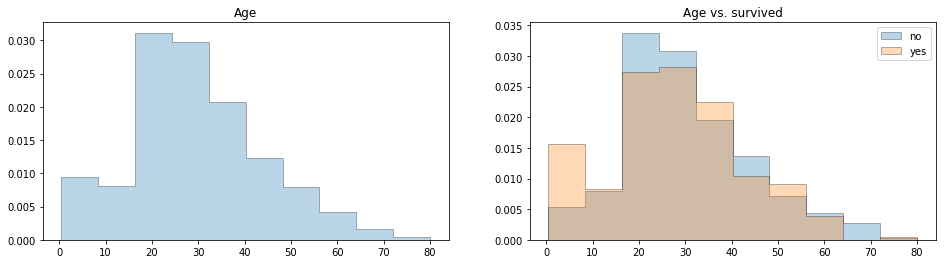

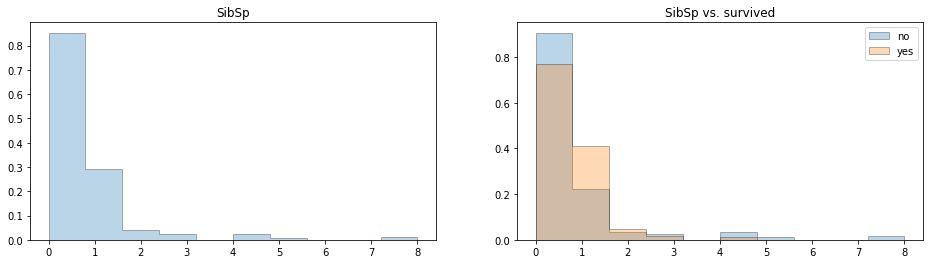

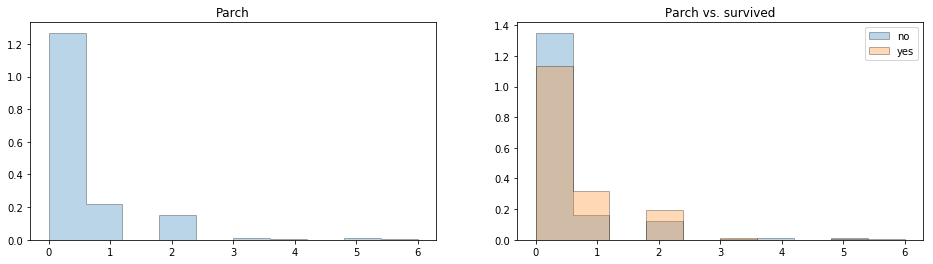

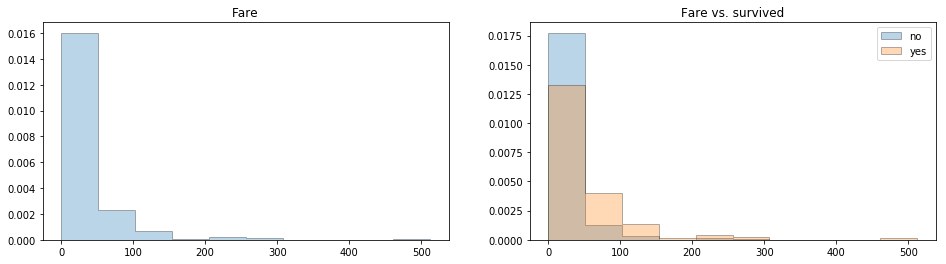

In [15]:
kwargs = dict(histtype = 'stepfilled', alpha = 0.3, density = True, ec = 'k')

for n in numerical:
    df = df_training[df_training[n].notnull()]
    x = df[n].values
    y = df[dependent].values
    
    fig, ax = plt.subplots(1, 2)
    (_, bins, _) = ax[0].hist(x, **kwargs)
    ax[0].set_title(n)
    
    x_0 = x[np.where(y == 0)]
    x_1 = x[np.where(y == 1)]
    ax[1].hist(x_0, **kwargs, bins = bins)
    ax[1].hist(x_1, **kwargs, bins = bins)
    ax[1].legend(['no', 'yes'])
    ax[1].set_title(n + ' vs. survived')
    
    fig.set_figwidth(16)

It seems that all the numerical features may provide useful information in predicting the dependent variable:

* Younger passengers are more likely to survive
* Passengers with not too few or too many embarked siblings/spouses are more likely to survive
* Passengers are more likely to survive if they embarked with parents/children
* Cheaper fares are less likely to survive.

Let's take a look at the categorical features now. 

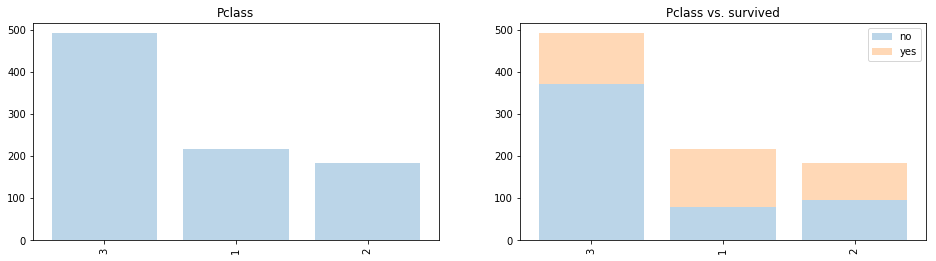

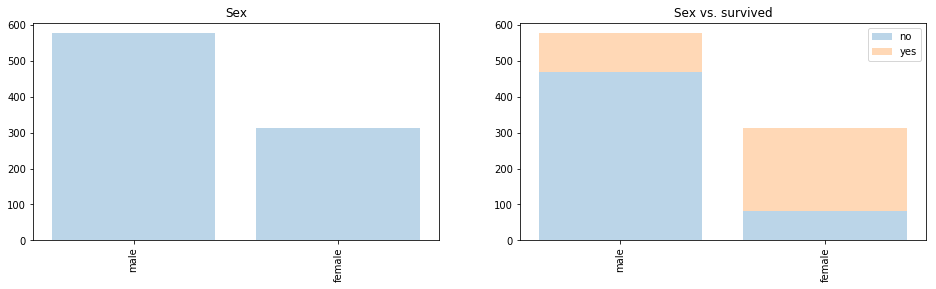

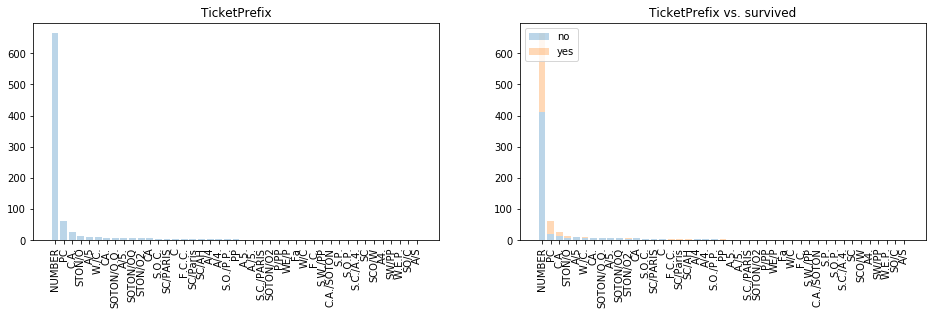

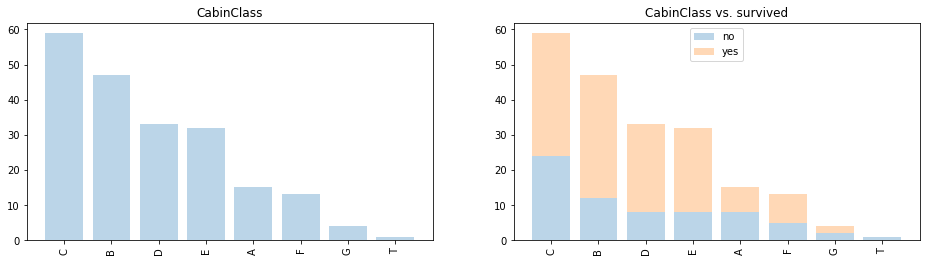

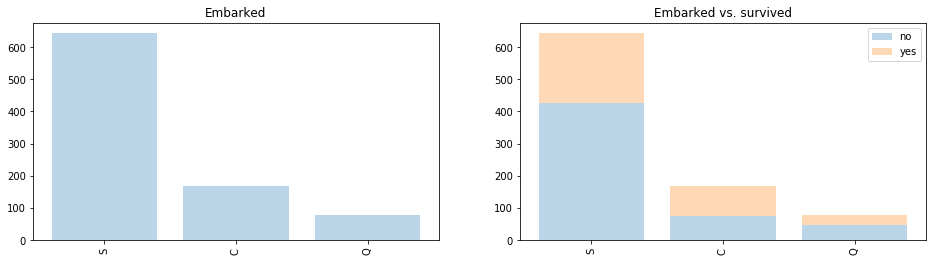

In [16]:
for c in categorical:
    df = df_training[df_training[c].notnull()]
    
    fig, ax = plt.subplots(1, 2)
    freqs = df[c].value_counts()
    labels = freqs.keys()
    ax[0].bar(range(len(labels)), freqs.values, alpha = 0.3)
    ax[0].set_xticks(range(len(labels)))
    ax[0].set_xticklabels(labels, rotation = 'vertical')
    ax[0].set_title(c)
    
    freqs_01 = df.groupby('Survived')[c].value_counts()
    ax[1].bar(range(len(labels)), freqs_01[0][labels].values, alpha = 0.3)
    ax[1].bar(range(len(labels)), freqs_01[1][labels].values, bottom = freqs_01[0][labels].values, alpha = 0.3)
    ax[1].set_xticks(range(len(labels)))
    ax[1].set_xticklabels(labels, rotation = 'vertical')
    ax[1].legend(['no', 'yes'])
    ax[1].set_title(c + ' vs. survived')
    
    fig.set_figwidth(16)

Most of the categorical features seem to also provide information about survival likelihood. For instance, it is more likely to survive if you are a woman, or if your cabin prefix is not T. Many of the passengers with ticket class = 1 did not survived. 

## Imputing missing values

Let's take a look at the proportion of missing data. Some of the fare values are zero, but we decided not to assume that this is bogus data. I am assumming that these 17 passengers travelled with a zero fare for an explainable reason. 

In [17]:
def test_missing():
    for col in numerical + categorical:
        if col in categorical:
            missing = df_training[df_training[col].isna()]
        else:
            missing = df_training[(df_training[col].isna()) | 
                                  (df_training[col].apply(lambda x: type(x) == str))]
        proportion = len(missing) / len(df_training) * 100
        print(col + ': ' + str(proportion) + '%')

In [18]:
test_missing()

Age: 19.865319865319865%
SibSp: 0.0%
Parch: 0.0%
Fare: 0.0%
Pclass: 0.0%
Sex: 0.0%
TicketPrefix: 0.0%
CabinClass: 77.10437710437711%
Embarked: 0.22446689113355783%


We have two categorical variables (CabinClass and Embarked) and one numerica variable (age) with missing values. I am going to assign a new value 'Missing' to the case of the missing values for the categorical variables. For the imputation of the numerical variable I am going to go for something simple and just use the median imputation.

In [19]:
# Categorical variables
for c in ['CabinClass', 'Embarked']:
    df_training.loc[df_training[c].isna(), c] = 'None'
    df_test.loc[df_training[c].isna(), c] = 'None'

In [20]:
# Numerical variable
imputed = df_training[np.isreal(df_training['Age'])]['Age'].median()
df_training.loc[(df_training['Age'].isna()) | (~np.isreal(df_training['Age'])), 'Age'] = imputed
df_test.loc[(df_test['Age'].isna()) | (~np.isreal(df_test['Age'])), 'Age'] = imputed

# It turns out that the test data has a missing fare
imputed = df_training[np.isreal(df_training['Fare'])]['Fare'].median()
df_test.loc[(df_test['Fare'].isna()) | (~np.isreal(df_test['Fare'])), 'Fare'] = imputed

In [21]:
test_missing()

Age: 0.0%
SibSp: 0.0%
Parch: 0.0%
Fare: 0.0%
Pclass: 0.0%
Sex: 0.0%
TicketPrefix: 0.0%
CabinClass: 0.0%
Embarked: 0.0%


## Correlation between variables

We calculate pearson correlation in order to determine whether we should remove any variable. 

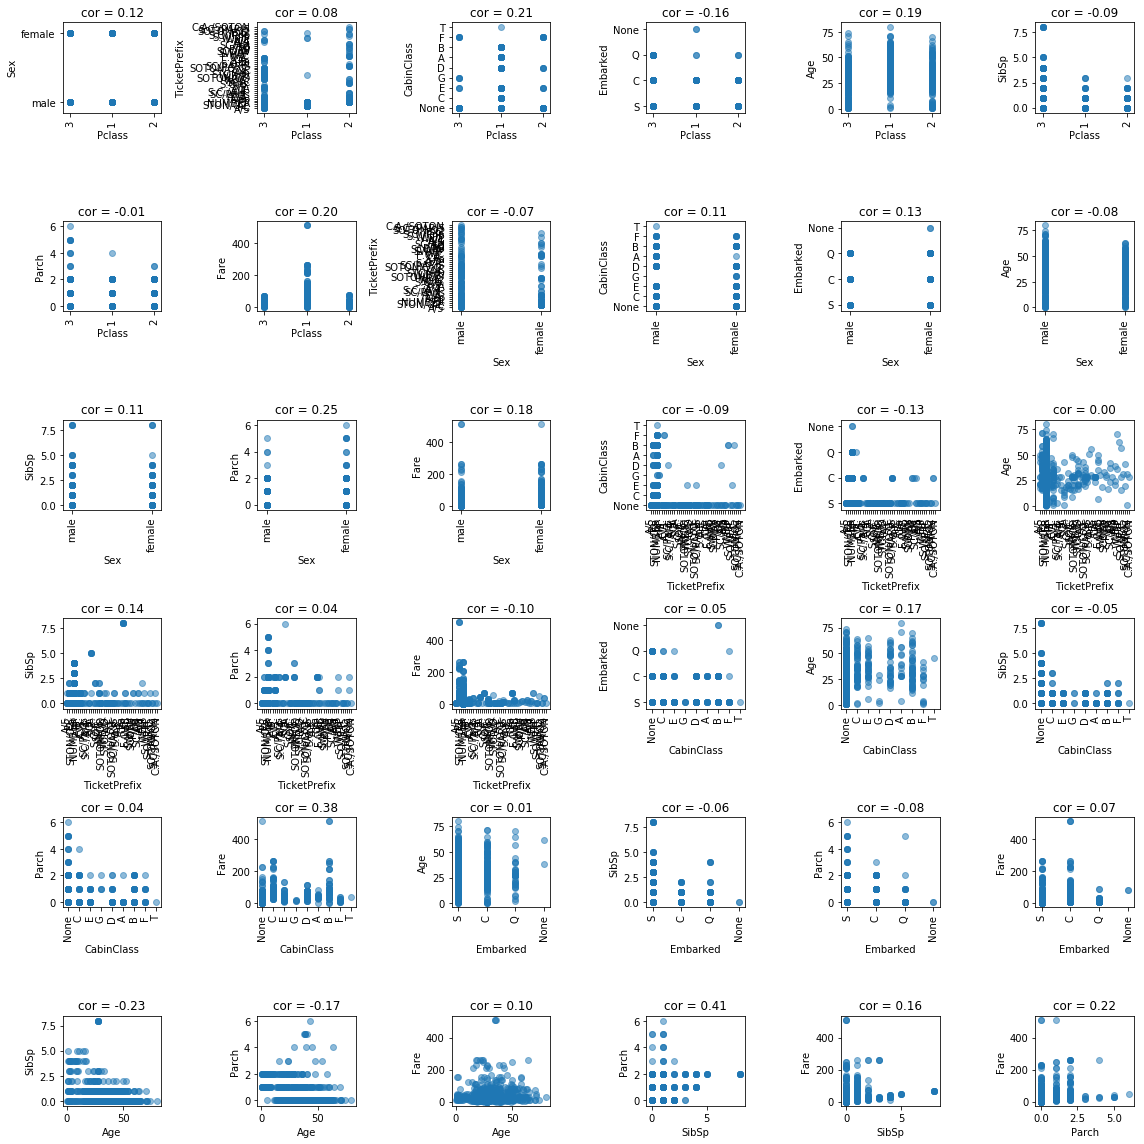

In [22]:
features = categorical + numerical

fig, ax = plt.subplots(6, 6)

plots = 0
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        row = int(plots / 6)
        col = plots % 6

        def categorical_to_numerical(f):
            if features[f] in numerical:
                values_f = df_training[features[f]]
            else:
                values = df_training[features[f]].unique()
                values_f = df_training[features[f]].values.copy()
                for v in range(len(values)):
                    values_f[np.where(values_f == values[v])] = v
            
            return values_f
        
        values_i = categorical_to_numerical(i)
        values_j = categorical_to_numerical(j)
        
        cor = ((values_i - values_i.mean()) * (values_j - values_j.mean()) / \
              ((len(values_i) - 1) * values_i.std() * values_j.std())).sum()
            
        ax[row][col].scatter(values_i, values_j, alpha = 0.5)
        
        ax[row][col].set_xlabel(features[i])
        ax[row][col].set_ylabel(features[j])
        ax[row][col].set_title('cor = ' + '%.2f' % cor)
        
        if features[i] in categorical:
            values = df_training[features[i]].unique().tolist()
            ax[row][col].set_xticks(range(len(values)))
            ax[row][col].set_xticklabels(values, rotation = 'vertical')
        if features[j] in categorical:
            values = df_training[features[j]].unique().tolist()
            ax[row][col].set_yticks(range(len(values)))
            ax[row][col].set_yticklabels(values)

        plots = plots + 1
        
fig.set_figwidth(16)
fig.set_figheight(16)
plt.tight_layout()

I don't observe any strong correlation. I cannot observe any obvious outlier either. 

## Dummy variables

Transforming categorical variables into dummy variables (we create k-1 new binary variables for each categorical variable, where k is the number of values of that categorical variable).

In [23]:
new_categorical = []
for c in categorical:
    values = df_training[c].unique()[:-1]
    for v in values:
        name = c + '_' + str(v)
        df_training[name] = (df_training[c] == v).astype(int)
        df_test[name] = (df_test[c] == v).astype(int)
        new_categorical.append(name)
    df_training = df_training.drop(c, axis = 1)
    df_test = df_test.drop(c, axis = 1)

In [24]:
print(len(categorical + numerical))

9


In [25]:
variables = new_categorical + numerical
print(len(variables))

60


After this step our training dataset contains 60 variables instead of 9.

## Standardise

We want to keep the correlation between variables. Therefore, we use standardisation instead of normalisation. This step is not necessary for some machine learning algorithms, but can help others to converge much faster and also to prevent bias in those machine learning algorithms based on the Euclidean distance. 

In [26]:
# Keeping this values to transform the test dataset
statistics = pd.concat((df_training.mean(), df_training.std()), axis = 1)
statistics.columns = ['mean', 'std']
statistics.head()

,mean,std
PassengerId,446.000000,257.353842
Survived,0.383838,0.486592
Age,29.361582,13.019697
SibSp,0.523008,1.102743
Parch,0.381594,0.806057


In [27]:
for c in variables:
    mean = statistics.loc[c, 'mean']
    std = statistics.loc[c, 'std']
    df_training[c] = (df_training[c] - mean) /  std
    df_test[c] = (df_test[c] - mean) /  std

In [28]:
df_training[variables].head()

,Pclass_3,Pclass_1,Sex_male,TicketPrefix_A/5,TicketPrefix_PC,TicketPrefix_STON/O2.,TicketPrefix_NUMBER,TicketPrefix_PP,TicketPrefix_A/5.,TicketPrefix_C.A.,...,CabinClass_A,CabinClass_B,CabinClass_F,Embarked_S,Embarked_C,Embarked_Q,Age,SibSp,Parch,Fare
0,0.902081,-0.565368,0.737281,9.380891,-0.268554,-0.082292,-1.714402,-0.058091,-0.088936,-0.176677,...,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739,-0.565419,0.432550,-0.473408,-0.502163
1,-1.107304,1.766775,-1.354813,-0.106480,3.719470,-0.082292,-1.714402,-0.058091,-0.088936,-0.176677,...,-0.130783,-0.235849,-0.121613,-1.613803,2.073341,-0.30739,0.663488,0.432550,-0.473408,0.786404
2,0.902081,-0.565368,-1.354813,-0.106480,-0.268554,12.138141,-1.714402,-0.058091,-0.088936,-0.176677,...,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739,-0.258192,-0.474279,-0.473408,-0.488580
3,-1.107304,1.766775,-1.354813,-0.106480,-0.268554,-0.082292,0.582639,-0.058091,-0.088936,-0.176677,...,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739,0.433068,0.432550,-0.473408,0.420494
4,0.902081,-0.565368,0.737281,-0.106480,-0.268554,-0.082292,0.582639,-0.058091,-0.088936,-0.176677,...,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739,0.433068,-0.474279,-0.473408,-0.486064


## Class imbalance

Finally we test whether the training set has a class imbalance problem. 

In [29]:
print(str((df_training.Survived == 1).sum()) + ' rows have Survived = 1')
print(str((df_training.Survived == 0).sum()) + ' rows have Survived = 0')

342 rows have Survived = 1
549 rows have Survived = 0


There's some imbalance in the data, but does not seem to extreme. I decided not to oversample the minority class. 

## Saving the data

In [30]:
c = ['Name', 'Ticket', 'Cabin']
df_training = df_training.drop(c, axis = 1)
df_test = df_test.drop(c, axis = 1)

df_training.to_csv('../../datasets/titanic_training_processed.csv', index = False)
df_test.to_csv('../../datasets/titanic_test_processed.csv', index = False)